In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [10]:
from jupyter_bbox_widget import BBoxWidget
import numpy as np
from src.extensions.metrics.ot_cost import get_ot_cost
import ipywidgets as widgets
import re
import matplotlib.pyplot as plt
from src.extensions.metrics.ot_cost import add_label, get_bbox_overlaps
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm
%matplotlib notebook

In [28]:
def display_alignment():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    fmt_gt_bboxes, gt_bbox_indices = format_bboxes(gt_bboxes, CLASS_LABELS, return_orders=True)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    fmt_bboxes, bbox_indices = format_bboxes(bboxes, CLASS_LABELS, return_orders=True)
    otc, log = get_ot_cost(fmt_gt_bboxes, fmt_bboxes, get_distmap_bg, return_matrix=True)

    img = plt.imread("data/sample_img/fruits.jpeg")
    plt.imshow(img)
    ax = plt.gca()

    # draw gt bboxes
    color = cm.rainbow(np.linspace(0, 1, len(gt_bboxes)+1))
    for bi, c in zip(gt_bbox_indices, color):
        b = gt_bboxes[bi]
        rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, edgecolor=c, fc="None")
        ax.add_patch(rect)   

    # draw bboxes
    for weight, c in zip(log["G"], color):
        for bi, w in zip(bbox_indices, weight):
            b = bboxes[bi]
            rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, ec=c, fc=c, alpha=w*2)
            ax.add_patch(rect)   

    plt.show()

In [4]:
from src.extensions.metrics.ot_cost import add_label, get_bbox_overlaps

def get_distmap_bg(a_result, b_result, mode="giou"):
    """[summary]

    Args:
        a_result ([type]): ground truth bounding boxes.
        b_result ([type]): predictions
        mode (str, optional): [description]. Defaults to "giou".

    Returns:
        dist_a (np.array): (N+1,) array. distribution over ground truth bounding boxes.
        dist_b (np.array): (M,) array. distribution over predictions.
        cost_map: 
    """
    a_result = add_label(a_result)
    b_result = add_label(b_result)
    n = len(a_result)
    m = len(b_result)
    r = m - n

    cost_map = np.zeros((n+1, m))

    dist_iou = get_bbox_overlaps(a_result[:, :4], b_result[:, :4], mode=mode)

    if mode == "giou":  # giou range [-1, 1] -> [0, 1]
        dist_iou += 1
        dist_iou *= 0.5

    dist_iou = 1 - dist_iou
    cost_map[:n, :m] = dist_iou * .5

    dist_cls = np.zeros((n+1, m))

    for i in range(n):
        for j in range(m):
            if a_result[i, -1] == b_result[j, -1]:
                dist_cls[i, j] = a_result[i, -2] - b_result[j, -2]
            else:
                dist_cls[i, j] = a_result[i, -2] + b_result[j, -2]
    dist_cls[-1, :] = [1 + b[-2] for b in b_result]

    dist_cls = np.abs(dist_cls * 0.5)
    cost_map += dist_cls * 0.5

    dist_a = np.ones(n+1)
    dist_a[-1] = max(r, 0)
    dist_a /= dist_a.sum()

    dist_b = np.ones(m) / m

    return dist_a, dist_b, cost_map

In [13]:
from ipywidgets import interactive
from IPython.display import display

CLASS_LABELS = ["apple", "lemon", "banana"]
n_class = len(CLASS_LABELS)
img_file = 'data/sample_img/fruits.jpeg'

def f():
    x, y, w, h = 10, 50, 30, 40 + np.random.randint(10)
    rect = Rectangle((x, y), w, h, lw=2, fc="None")
    ax[0].add_patch(rect)   

fig, ax = plt.subplots(ncols=2, figsize=(5,5))
im = plt.imread(img_file)
ax[0].imshow(im)

out = interactive(f)

bbox_widget = BBoxWidget(
    image="../../"+img_file,
    classes= CLASS_LABELS + [" ".join(["GT", l]) for l in CLASS_LABELS],
    colors=["green"] * n_class + ["orange"] * n_class,
    hide_buttons=True
    )

w_conf = widgets.FloatSlider(value=0.5, min=0, max=1., description='Confidence')
bbox_widget.attach(w_conf, name="confidence")

def format_bboxes(bboxes, classes, return_orders=False):
    orders = []
    formatted_bboxes = []
    for label in classes:
        formatted_bboxes.append([])
        for i, bbox in enumerate(bboxes):
            if label in bbox["label"]:
                if bbox["label"].startswith("GT"):
                    conf = 1 
                else:
                    conf = bbox["confidence"]
                formatted_bboxes[-1].append([bbox["x"], bbox["y"], bbox["x"]+bbox["width"], bbox["y"]+bbox["height"], conf])
                orders.append(i)
        formatted_bboxes[-1] = np.asarray(formatted_bboxes[-1], dtype=np.float32).reshape(-1, 5)
    if return_orders:
        return formatted_bboxes, orders
    return formatted_bboxes
    
def evaluate_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    otc, log = get_ot_cost(gt_bboxes, bboxes, get_distmap_bg, return_matrix=True)
    return otc, log

w_out = widgets.Output()

def update_label_conf():
    idx = bbox_widget.selected_index
    cur_label = bbox_widget.bboxes[idx]["label"]

    if cur_label.startswith("GT"):
        return

    if "(" not in cur_label:
        cur_label += " ( )"

    conf = bbox_widget.bboxes[idx]["confidence"]
    new_label = re.sub(r"\(.*\)", f"({conf})", cur_label)

    bbox_widget._set_bbox_property(idx, "label", new_label)

def on_bbox_change(change):
    update_label_conf()

    w_out.clear_output(wait=True)
    otc, log = evaluate_bboxes()
    with w_out:
        print(f"{otc:.3f}")
        print(log['G'])
        
bbox_widget.observe(on_bbox_change, names=['bboxes'])

# button = widgets.Button(
#     description='Display alignment',
#     disabled=False,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     tooltip='Display alignment',
#     icon='check' # (FontAwesome names without the `fa-` prefix)
# )
# button.on_click(display_alignment)
w_container = widgets.VBox([
    bbox_widget,
    w_conf,
    w_out,
    # button
])
display(w_container)

<IPython.core.display.Javascript object>

In [15]:
type(out)

ipywidgets.widgets.interaction.interactive

In [5]:
import ot

def get_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    return gt_bboxes, bboxes

gt_bboxes, bboxes = get_bboxes()
a, b, M = get_distmap_bg(gt_bboxes, bboxes)
# ot.emd2(a, b, M, return_matrix=True)

In [9]:
bboxes

[array([[319. , 281. , 495. , 406. ,   0.5]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

[0.33333333 0.         0.        ]
[0.         0.33333333 0.        ]
[0.         0.         0.33333333]
[0. 0. 0.]


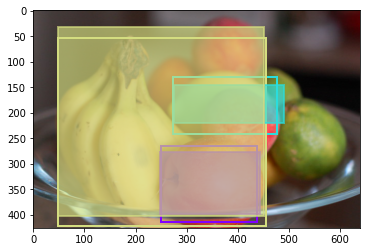